In [140]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from tqdm import tqdm
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

### Data Loading

The chosen original data was [Job Vacancy Rate, Euro area 20 (fixed composition) as of 1 January 2023, Quarterly](https://data.ecb.europa.eu/data/datasets/JVS/JVS.Q.I9._Z.N.JVR.P._T._T) in the field of **Education**.

In [141]:
# load original data
df_original = pd.read_csv('HWIII_original_data_Hashemi.csv')
df_original.columns = ['date', 'time-period', 'job-vacancy-rate']
df_original.head()

,date,time-period,job-vacancy-rate
0,2010-12-31,2010Q4,0.8
1,2011-03-31,2011Q1,0.8
2,2011-06-30,2011Q2,1.0
3,2011-09-30,2011Q3,1.1
4,2011-12-31,2011Q4,0.7


Now, for additional data, I chose [Job vacancy rate, Euro area 20 (fixed composition) as of 1 January 2023, Quarterly](https://data.ecb.europa.eu/data/datasets/JVS/JVS.Q.I9._Z.N.JVR.K._T._T) in the field of **Financial and insurance activities**

In [142]:
# load additional data
df_additional = pd.read_csv('HWIII_additional_data_Hashemi.csv')
df_additional.columns = ['date', 'time-period', 'job-vacancy-rate']
df_additional.head()

,date,time-period,job-vacancy-rate
0,2010-12-31,2010Q4,1.3
1,2011-03-31,2011Q1,1.2
2,2011-06-30,2011Q2,1.1
3,2011-09-30,2011Q3,1.0
4,2011-12-31,2011Q4,1.2


In [143]:
def coverting_to_stationary(df):
    '''
        Plot first differences of the series and AC& PAC

        pct_change()
        Computes the fractional change from the immediately previous row by default. 
        This is useful in comparing the fraction of change in a time series of elements.
    '''
    df_diff = pd.DataFrame()
    
    df_diff['dy'] = df['job-vacancy-rate'].pct_change()
    df_diff['date'] = pd.to_datetime(df['date']).dt.date
    df_diff = df_diff.dropna()

    fig, axs = plt.subplots(1, 3,figsize=(16,8))
    axs[0].plot(df_diff['dy'])
    axs[0].set_xticks(np.arange(0,len(df_diff['dy']),10))                                                       # display every 10-th tick
    axs[0].set_xticklabels(df_diff.date[np.arange(1,len(df_diff['dy'])+1,10)],rotation=20)                            # label ticks
    axs[0].set_xlabel('Time', fontsize=10)
    axs[0].set_ylabel('Job Vacancy Rate Difference(%)', fontsize=10)

    sm.graphics.tsa.plot_acf(df_diff['dy'], lags=10, ax=axs[1])
    axs[1].set_xlabel('Lag', fontsize=10)
    axs[1].set_ylabel('ACF', fontsize=10)

    sm.graphics.tsa.plot_pacf(df_diff['dy'], lags=10, ax=axs[2])
    axs[2].set_xlabel('Lag', fontsize=10)
    axs[2].set_ylabel('PACF', fontsize=10)

    plt.tight_layout()
    plt.show()
    
    return df_diff

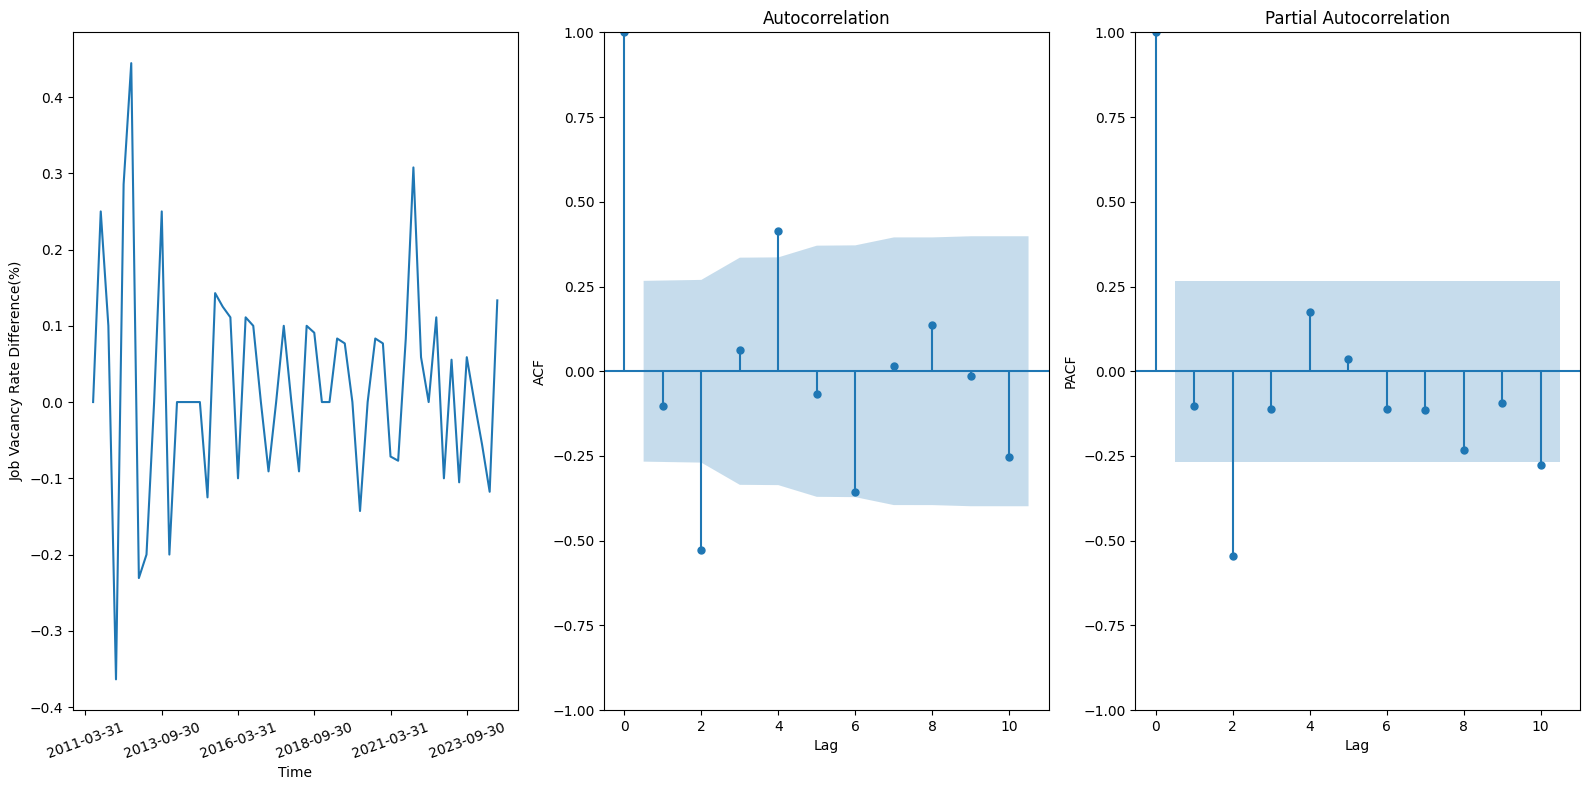

,dy,date
1,0.000000,2011-03-31
2,0.250000,2011-06-30
3,0.100000,2011-09-30
4,-0.363636,2011-12-31
5,0.285714,2012-03-31


In [144]:
df_original_diff = coverting_to_stationary(df_original)
df_original_diff.head()

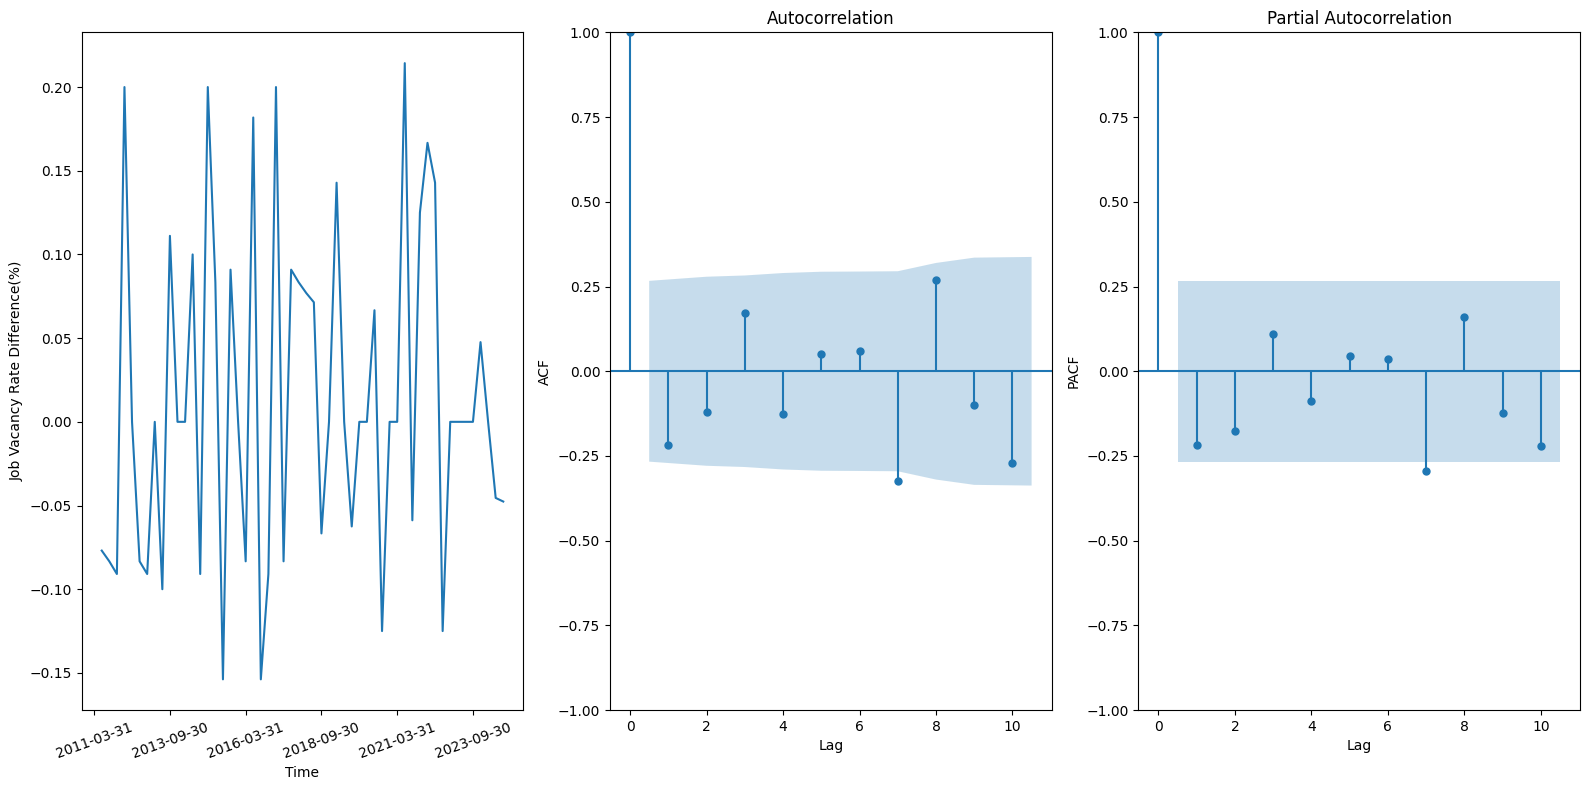

,dy,date
1,-0.076923,2011-03-31
2,-0.083333,2011-06-30
3,-0.090909,2011-09-30
4,0.200000,2011-12-31
5,0.000000,2012-03-31


In [145]:
df_additional_diff = coverting_to_stationary(df_additional)
df_additional_diff.head()

### [NN forecast]

In [146]:
# merging two dataframes
merged_df = pd.merge(df_original_diff, df_additional_diff, on='date', suffixes=('_original', '_additional'))
dataset = merged_df.drop(columns=['date'])

In [147]:
# Windowing data is a common technique in time series data
def create_windowed_dataset(data, window_size, output_size):
    windows = []
    for i in range(len(data) - window_size - output_size):
        x = data[i:i + window_size].flatten()
        y = data[i + window_size : i + window_size + output_size, :].flatten()
        windows.append((x, y))
    return windows

windows = create_windowed_dataset(dataset.values, 5, 1)     # window size = 5x2, output size = 1x2
print(windows[0])

(array([ 0.        , -0.07692308,  0.25      , -0.08333333,  0.1       ,
       -0.09090909, -0.36363636,  0.2       ,  0.28571429,  0.        ]), array([ 0.44444444, -0.08333333]))


In [148]:
X = torch.tensor([w[0] for w in windows], dtype=torch.float32)
y = torch.tensor([w[1] for w in windows], dtype=torch.float32)

In [149]:
class TimeSeriesNN(nn.Module):
    '''
        A simple neural network for time series forecasting
    '''
    def __init__(self, input_size, output_size):
        super(TimeSeriesNN, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_size)
        )

    def forward(self, x):
        return self.mlp(x)

In [150]:
input_size = X.shape[1]
output_size = y.shape[1]

tensor_dataset = TensorDataset(X, y)
train_size = int(0.8 * len(tensor_dataset))
train_dataset, val_dataset = torch.utils.data.random_split(tensor_dataset, [train_size, len(tensor_dataset) - train_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

model = TimeSeriesNN(input_size, output_size)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 30
train_losses = []
val_losses = []

for epoch in tqdm(range(n_epochs)):
    model.train()
    train_loss = 0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader)) 

    model.eval()
    val_loss = 0
    predictions = []
    actuals = []
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item()
            predictions.extend(y_pred)
            actuals.extend(y_batch)
    val_losses.append(val_loss / len(val_loader))

    predictions = np.array(predictions)
    actuals = np.array(actuals)
    print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

100%|██████████| 30/30 [00:00<00:00, 1266.04it/s]

Epoch [1/30], Training Loss: 0.0391, Validation Loss: 0.0120
Epoch [2/30], Training Loss: 0.0239, Validation Loss: 0.0115
Epoch [3/30], Training Loss: 0.0187, Validation Loss: 0.0116
Epoch [4/30], Training Loss: 0.0209, Validation Loss: 0.0119
Epoch [5/30], Training Loss: 0.0209, Validation Loss: 0.0123
Epoch [6/30], Training Loss: 0.0227, Validation Loss: 0.0125
Epoch [7/30], Training Loss: 0.0219, Validation Loss: 0.0127
Epoch [8/30], Training Loss: 0.0231, Validation Loss: 0.0127
Epoch [9/30], Training Loss: 0.0245, Validation Loss: 0.0127
Epoch [10/30], Training Loss: 0.0216, Validation Loss: 0.0125
Epoch [11/30], Training Loss: 0.0260, Validation Loss: 0.0124
Epoch [12/30], Training Loss: 0.0188, Validation Loss: 0.0122
Epoch [13/30], Training Loss: 0.0270, Validation Loss: 0.0120
Epoch [14/30], Training Loss: 0.0199, Validation Loss: 0.0117
Epoch [15/30], Training Loss: 0.0194, Validation Loss: 0.0114
Epoch [16/30], Training Loss: 0.0166, Validation Loss: 0.0111
Epoch [17/30], Tr

In [151]:
rmsfe = np.sqrt(mean_squared_error(actuals[:,0], predictions[:,0]))
print(f'Root Mean Squared Forecast Error (RMSFE): {rmsfe:.4f}')


Root Mean Squared Forecast Error (RMSFE): 0.1046


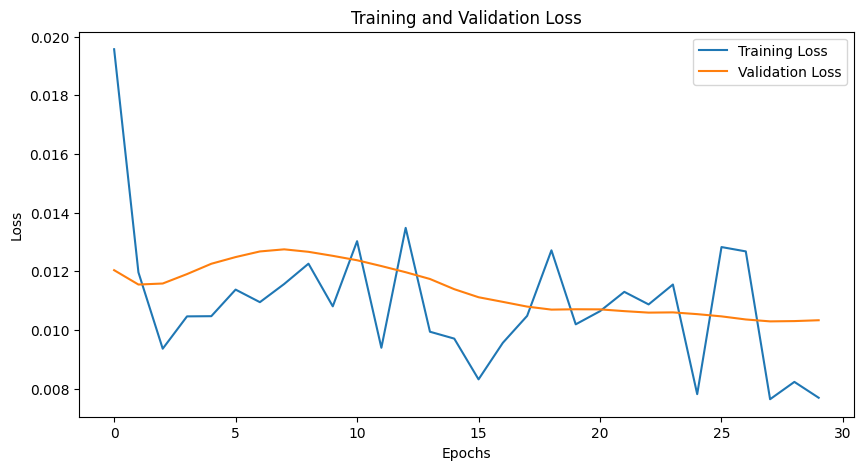

In [152]:
plt.figure(figsize=(10, 5))
plt.plot(range(n_epochs), train_losses, label='Training Loss')
plt.plot(range(n_epochs), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

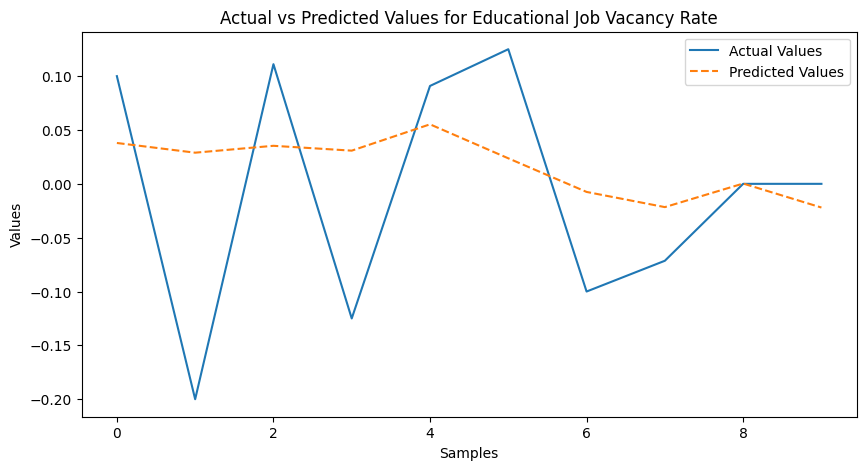

In [153]:
# Plotting the actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(actuals[:,0], label='Actual Values')
plt.plot(predictions[:,0], label='Predicted Values', linestyle='dashed')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values for Educational Job Vacancy Rate')
plt.legend()
plt.show()

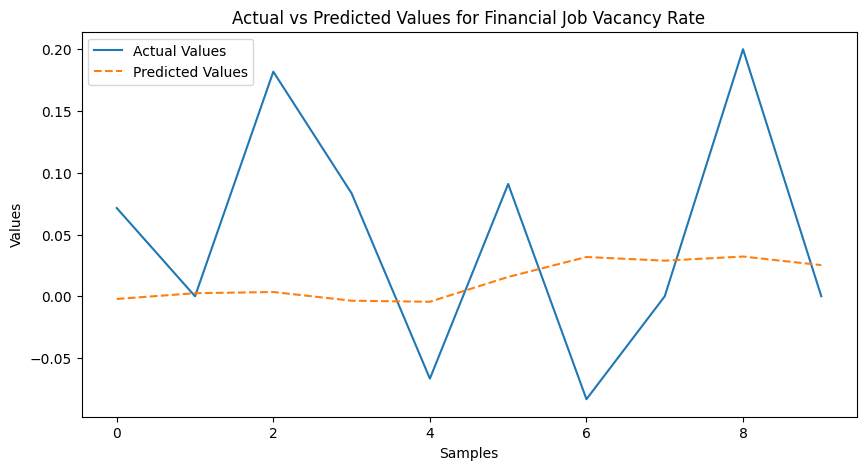

In [154]:
# Plotting the actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(actuals[:,1], label='Actual Values')
plt.plot(predictions[:,1], label='Predicted Values', linestyle='dashed')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values for Financial Job Vacancy Rate')
plt.legend()
plt.show()

### Training Neural Network on the Main Dataset (not the stationary one)

Since the two datasets are behaving similarly, however, their stationary versions are not, we will train the neural network on the main dataset as well to see the results.

In [155]:
# merging two dataframes
merged_original_df = pd.merge(df_original, df_additional, on='date', suffixes=('_original', '_additional'))
dataset_original = merged_original_df.drop(columns=['time-period_original', 'time-period_additional', 'date'])
dataset_original.head()

,job-vacancy-rate_original,job-vacancy-rate_additional
0,0.8,1.3
1,0.8,1.2
2,1.0,1.1
3,1.1,1.0
4,0.7,1.2


In [156]:
windows_original = create_windowed_dataset(dataset_original.values, 5, 1)
print(windows_original[0])

(array([0.8, 1.3, 0.8, 1.2, 1. , 1.1, 1.1, 1. , 0.7, 1.2]), array([0.9, 1.2]))


In [157]:
X_original = torch.tensor([w[0] for w in windows_original], dtype=torch.float32)
y_original = torch.tensor([w[1] for w in windows_original], dtype=torch.float32)

In [158]:
input_size = X_original.shape[1]
output_size = y_original.shape[1]

tensor_dataset = TensorDataset(X_original, y_original)
train_size = int(0.8 * len(tensor_dataset))
train_dataset, val_dataset = torch.utils.data.random_split(tensor_dataset, [train_size, len(tensor_dataset) - train_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

model = TimeSeriesNN(input_size, output_size)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 30
train_losses = []
val_losses = []

for epoch in tqdm(range(n_epochs)):
    model.train()
    train_loss = 0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader)) 

    model.eval()
    val_loss = 0
    predictions = []
    actuals = []
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item()
            predictions.extend(y_pred)
            actuals.extend(y_batch)
    val_losses.append(val_loss / len(val_loader))

    predictions = np.array(predictions)
    actuals = np.array(actuals)
    print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

100%|██████████| 30/30 [00:00<00:00, 1185.52it/s]

Epoch [1/30], Training Loss: 3.4705, Validation Loss: 1.6716
Epoch [2/30], Training Loss: 3.0098, Validation Loss: 1.4615
Epoch [3/30], Training Loss: 2.9699, Validation Loss: 1.2679
Epoch [4/30], Training Loss: 2.6817, Validation Loss: 1.0836
Epoch [5/30], Training Loss: 2.1429, Validation Loss: 0.9049
Epoch [6/30], Training Loss: 1.6826, Validation Loss: 0.7316
Epoch [7/30], Training Loss: 1.3041, Validation Loss: 0.5640
Epoch [8/30], Training Loss: 1.0230, Validation Loss: 0.4080
Epoch [9/30], Training Loss: 0.7404, Validation Loss: 0.2708
Epoch [10/30], Training Loss: 0.4502, Validation Loss: 0.1588
Epoch [11/30], Training Loss: 0.2523, Validation Loss: 0.0775
Epoch [12/30], Training Loss: 0.1153, Validation Loss: 0.0317
Epoch [13/30], Training Loss: 0.0671, Validation Loss: 0.0198
Epoch [14/30], Training Loss: 0.0582, Validation Loss: 0.0324
Epoch [15/30], Training Loss: 0.1140, Validation Loss: 0.0528
Epoch [16/30], Training Loss: 0.1387, Validation Loss: 0.0651
Epoch [17/30], Tr

In [164]:
rmsfe = np.sqrt(mean_squared_error(actuals[:,0], predictions[:,0]))
print(f'Root Mean Squared Forecast Error (RMSFE): {rmsfe:.4f}')

Root Mean Squared Forecast Error (RMSFE): 0.1630


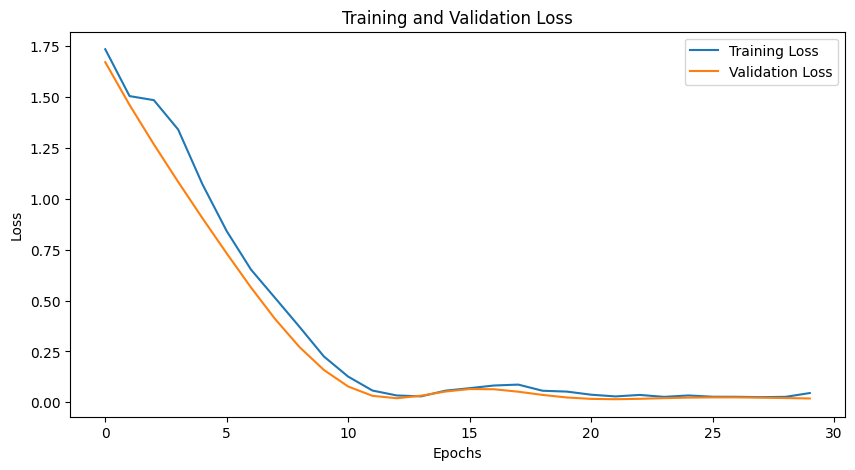

In [160]:
plt.figure(figsize=(10, 5))
plt.plot(range(n_epochs), train_losses, label='Training Loss')
plt.plot(range(n_epochs), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

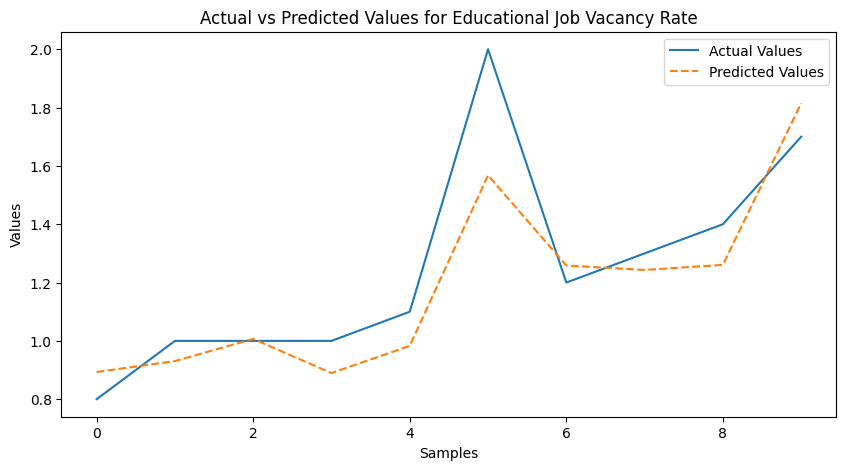

In [161]:
# Plotting the actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(actuals[:,0], label='Actual Values')
plt.plot(predictions[:,0], label='Predicted Values', linestyle='dashed')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values for Educational Job Vacancy Rate')
plt.legend()
plt.show()

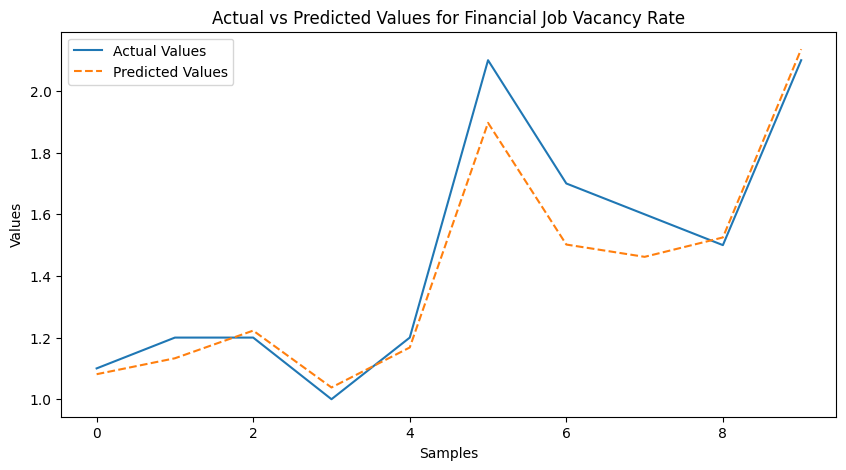

In [162]:
# Plotting the actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(actuals[:,1], label='Actual Values')
plt.plot(predictions[:,1], label='Predicted Values', linestyle='dashed')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values for Financial Job Vacancy Rate')
plt.legend()
plt.show()

### [Forecast comparison]

Since in the last homeworks, we worked with stationary data, here we consider the RMSE of the stationary data for comparison (and only considering the Main Dataset which is Educational Job Vacancy Rate)

HWIV (NN model) RMSE: 0.1046

HWII (ARIMA model) RMSE: 0.06733497633143967

HWIII (VAR model) RMSE: 0.09600144


First of all, I need to mention that all models are doing a good job in forecasting the data. However, the ARIMA model is the best among them. The NN model is the worst among them.

I expected NN to perform the best among all, however, the data had only 55 observations, and neural networks require huge amount of data to perform very well. Besides, NN are prone to overfitting, especially when the dataset is small. So these will explain why NN did not outperform ARIMA and VAR models.

Based on the research I did, ARIMA models are well-suited for stationary time series data (data whose statistical properties do not change over time)
